## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2, glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

if 0 == len(objpoints):
    print('length 0 objpoints')
else:
    print('objpoints: ', objpoints)



length 0 objpoints


## And so on and so forth...

In [2]:
#interrupt

In [3]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def makeCalibrationList():
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    print('images: ', images)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)
            cv2.waitKey(50)
        else:
            print('False ret')
         

    cv2.destroyAllWindows()
    return corners

#corners = []
if 0 == len(objpoints):
    print('length 0 objpoints')
    corners = makeCalibrationList()
else:
    print('objpoints length: ', len(objpoints) )

    

length 0 objpoints
images:  ['camera_cal/calibration14.jpg', 'camera_cal/calibration4.jpg', 'camera_cal/calibration20.jpg', 'camera_cal/calibration17.jpg', 'camera_cal/calibration11.jpg', 'camera_cal/calibration8.jpg', 'camera_cal/calibration7.jpg', 'camera_cal/calibration13.jpg', 'camera_cal/calibration6.jpg', 'camera_cal/calibration3.jpg', 'camera_cal/calibration19.jpg', 'camera_cal/calibration16.jpg', 'camera_cal/calibration15.jpg', 'camera_cal/calibration18.jpg', 'camera_cal/calibration1.jpg', 'camera_cal/calibration2.jpg', 'camera_cal/calibration9.jpg', 'camera_cal/calibration5.jpg', 'camera_cal/calibration10.jpg', 'camera_cal/calibration12.jpg']
False ret
False ret
False ret


In [4]:
# Define a class to receive the characteristics of each line detection
class Line():
    warped = None
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.out_img = None
        

In [5]:
def undistortImg(image):
    # Do camera calibration given object points and image points
    img_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    #cv2.imwrite('calibration_wide/test_undist.jpg',dst)
    return undistorted


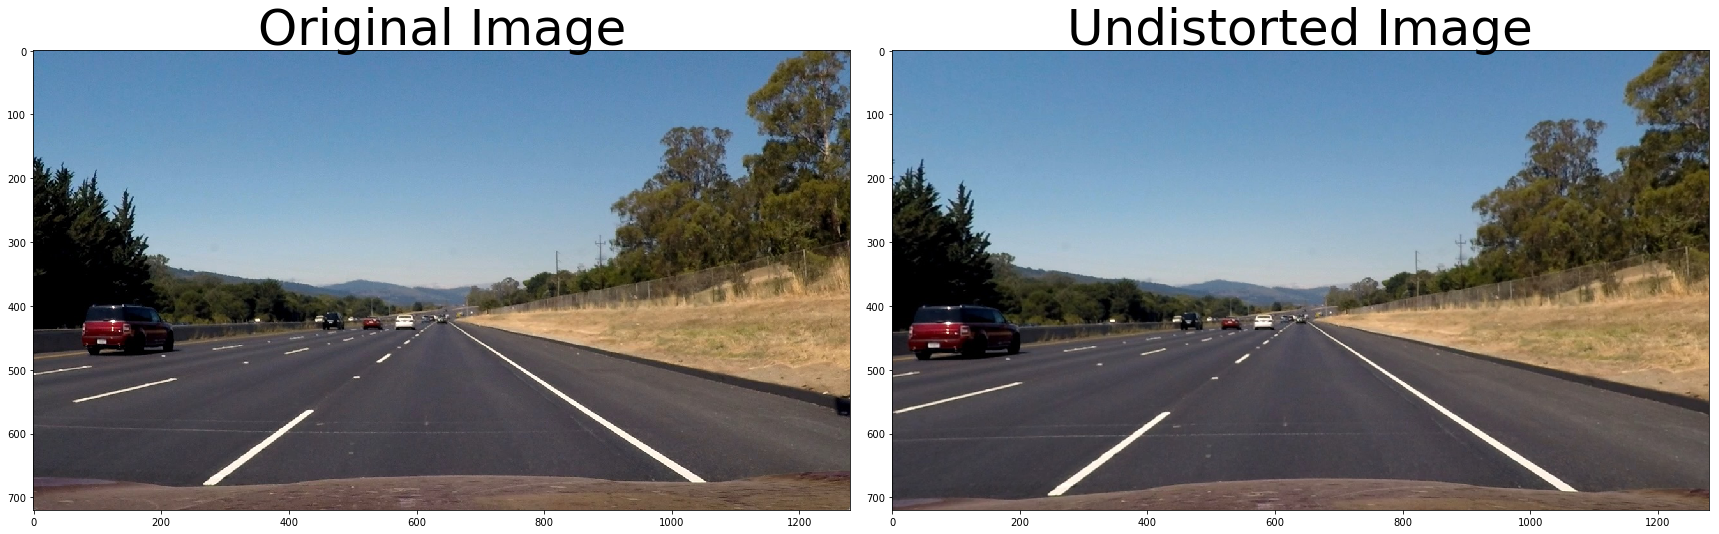

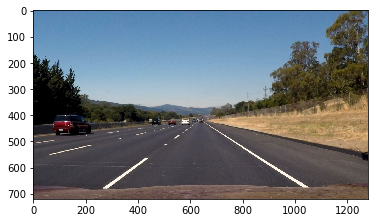

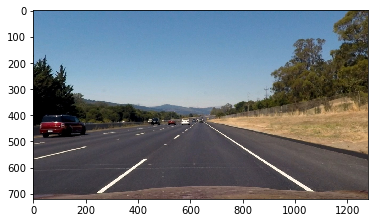

In [6]:
# test on a image
#filename = 'test_images/straight_lines1.jpg'
#filename = 'test_images/test6.jpg'
filename = 'test_images/straight_lines2.jpg'
#filename = 'test_images/solidYellowLeft.jpg'
#filename = 'test_images/test4.jpg'

image = mpimg.imread(filename)
#edgedetect = edgedetect(image)
undistorted = undistortImg(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
fig.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.show()

plt.imshow(image)
plt.show()

plt.imshow(undistorted)
plt.show()


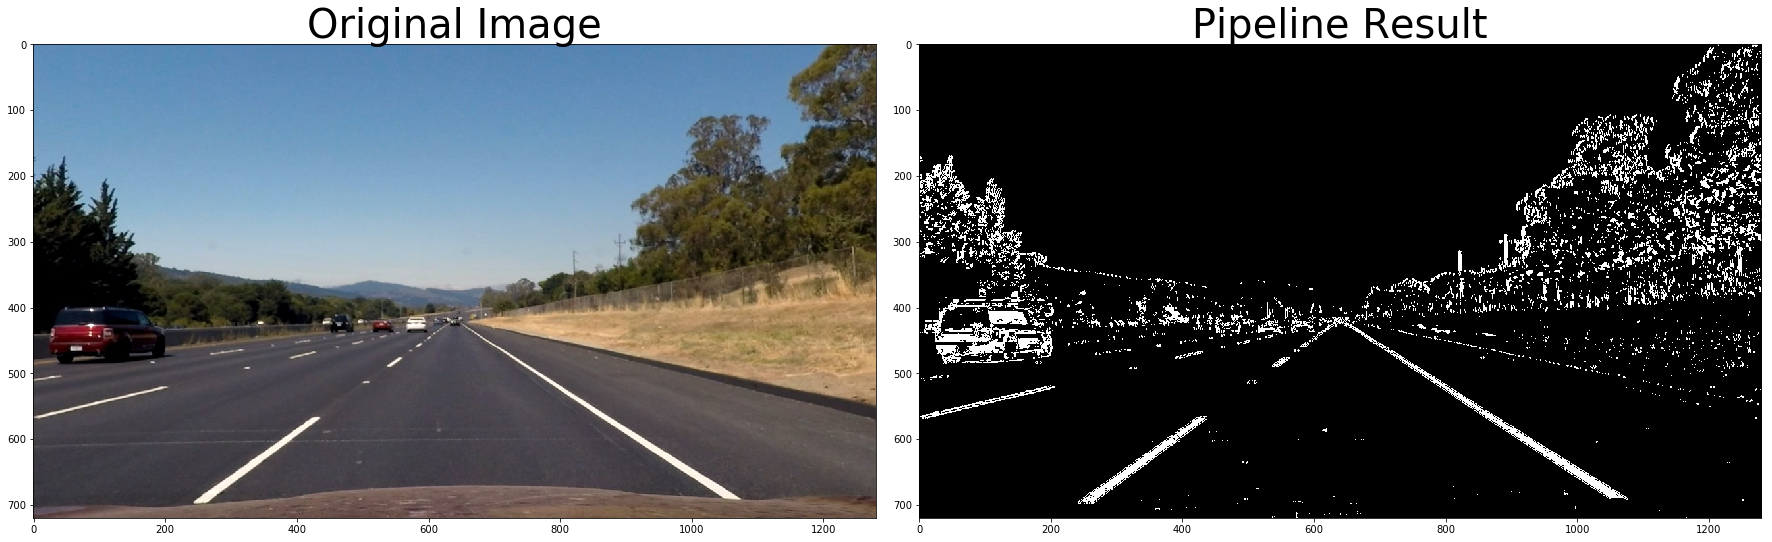

In [7]:
# from "30 Color and Gradient"
# Edit this function to create your own pipeline.
def colorandgradient(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

# plt.imshow(image)
# plt.show()

# result = colorandgradient(image, (180, 255), (60, 100) )
colorgrad = colorandgradient(undistorted )
# hough = houghgreen(result)
# plt.imshow(hough)
# plt.show()

# Iterate over the output "lines" and draw lines on a blank image
#line_image = np.copy(image)*0 # creating a blank to draw lines on
#draw_lines_extrapolate(line_image, lines, vertice_y, (255, 0, 0), 10)
#draw_lines
# lines_edges = weighted_img(image, hough)
# plt.imshow(lines_edges)
# plt.show()
#return lines_edges

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

#ax2.imshow(result)
ax2.imshow(colorgrad, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



In [8]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if (0 == len(lines) ):
        print('None == lines')
        return None
        
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
            
            
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)



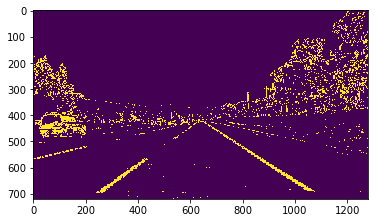

hough shape:  (720, 1280, 1)
hough shape:  (720, 1280)


In [9]:
def getvertices(imshape):
    vertice_y_up = 420
#    vertice_y_up = 440
    vertice_y_down = imshape[0] - 60
#    print('imshape[0]: ', imshape[0])
#    print('vertice_y_down: ', vertice_y_down)
    vertice_x_left = 550
    vertice_x_right = 650
    vertices = np.array([[(0, vertice_y_down),
                          (vertice_x_left, vertice_y_up),
                          (vertice_x_right, vertice_y_up), 
                          (imshape[1], vertice_y_down) ] ], dtype=np.int32)
#     vertices = np.array([[(250, vertice_y_down),
#                           (vertice_x_left, vertice_y_up),
#                           (vertice_x_right, vertice_y_up), 
#                           (1100, vertice_y_down) ] ], dtype=np.int32)
    return vertices
    
def houghbinary(image):
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
#     vertice_y = 420

    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid

    threshold = 25     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 15    # maximum gap in pixels between connectable line segments
    ch = 1
    
    imshape = image.shape
    vertices = getvertices(imshape)
    masked_edges = region_of_interest(image, vertices)

    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), minLineLength = min_line_len, maxLineGap = max_line_gap)
#     print('lines : ', lines)
    
    line_img = np.zeros((image.shape[0], image.shape[1], ch), dtype = np.uint8)
    draw_lines(line_img, lines, [0, 255, 0])
    
    # Iterate over the output "lines" and draw lines on a blank image
#     line_image = np.copy(image)*0 # creating a blank to draw lines on
#     draw_lines_extrapolate(line_image, lines, vertice_y, (255, 0, 0), 10)
#     lines_edges = weighted_img(image, line_image)
#     return lines_edges
    
#     lines_edges = weighted_img(image, line_img)
#     plt.imshow(lines_edges)
#     return lines_edges
    return line_img

hough = houghbinary(colorgrad)
plt.imshow(colorgrad)
plt.show()
print('hough shape: ', hough.shape)
print('hough shape: ', hough[:,:,-1].shape)


In [33]:
import matplotlib.image as mpimg
import numpy as np
import cv2
# from discussion forum.
# from discussion forum.
# https://discussions.udacity.com/t/perspective-transform/235255/7


def warp_image(img):
#     img = mpimg.imread(filename)
#     img = hough
#     img = colorgrad

    # https://discussions.udacity.com/t/perspective-transform/235255/7
    # LetTheAIDrive
    # i = 1
    # images = glob.glob('./test_images/*.jpg')
    # print('images[i] : ', images[i])
    # img = cv2.imread(images[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #### ???
    top_left = [630,420]
    top_right = [650,420]
    bottom_right = [1130,720]
    bottom_left = [200,720]
    pts = np.array([bottom_left,bottom_right,top_right,top_left])

    top_left_dst = [200,0]
    top_right_dst = [1130,0]
    bottom_right_dst = [1130,720]
    bottom_left_dst = [200,720]
    dst_pts = np.array([bottom_left_dst, bottom_right_dst, top_right_dst, top_left_dst])

    ## you can plot this and see that lines are properly chosen
    ## cv2.polylines(img,[pts],True,(255,0,0), 5)
    ## cv2.polylines(img,[dst_pts],True,(0,0,255), 5)
    pts = np.float32(pts.tolist())
    dst_pts = np.float32(dst_pts.tolist())

    ## M is the transformation matrix
    M = cv2.getPerspectiveTransform(pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, pts)

    # https://discussions.udacity.com/t/perspective-transform/235255/7
    # driveWell 
    w,h = 1280,720
    x,y = 0.5*w, 0.8*h
    src = np.float32([[200./1280*w,720./720*h],
                  [453./1280*w,547./720*h],
                  [835./1280*w,547./720*h],
                  [1100./1280*w,720./720*h]])
    dst = np.float32([[(w-x)/2.,h],
                  [(w-x)/2.,0.82*h],
                  [(w+x)/2.,0.82*h],
                  [(w+x)/2.,h]])
    ## M is the transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    Line.Minv = Minv

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (40, 15)) 
    image_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, dsize = image_size, flags = cv2.INTER_LINEAR)
    print('img.shape :', img.shape)
    print('warped.shape :', warped.shape)
    ax1.imshow(img) 
    ax2.imshow(warped)
    return warped, M, Minv


In [12]:
# 33 finding the lanes
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/c41a4b6b-9e57-44e6-9df9-7e4e74a1a49a
def fitlanes(warped):
    binary_warped = warped
    print('binary_warped.shape :', binary_warped.shape )
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2 :,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    print('out_img.shape :', out_img.shape )
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    print('midpoint :', midpoint, 'leftx_base :', leftx_base, 'rightx_base :', rightx_base )
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    print('nonzero :', nonzero, 'nonzeroy :', nonzeroy, nonzeroy.shape, 'nonzerox :', nonzerox, nonzerox.shape )
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    Line.margin = margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        try:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2)
        except:
            print(out_img.shape, win_xleft_low, win_y_low, win_xleft_high, win_y_high)
        try:
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        except:
            print(out_img.shape, win_xright_low, win_y_low, win_xright_high,win_y_high)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    #     print('good_left_inds: ', good_left_inds, 'good_right_inds: ', good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    Line.out_img = out_img
    Line.nonzero = nonzero
    Line.left_lane_inds = left_lane_inds
    Line.right_lane_inds = right_lane_inds
    
    return left_fit, right_fit

In [13]:
def drawfit(binary_warped, left_fit, right_fit):
    out_img = Line.out_img
    left_lane_inds = Line.left_lane_inds
    right_lane_inds = Line.right_lane_inds
    nonzero = Line.nonzero

    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    print('binary_warped.shape[0]-1 : ', binary_warped.shape[0]-1)
    print('binary_warped.shape[0] : ', binary_warped.shape[0])
    #print('ploty: ', ploty)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

    print('left_fit: ', left_fit)
    print('right_fit: ', right_fit)
    
    Line.left_fitx = left_fitx
    Line.right_fitx = right_fitx
    Line.ploty = ploty
    
    return left_fitx, right_fitx, ploty



In [14]:
def warpfromlastframe(binary_warped):
    out_img = Line.out_img
    left_lane_inds = Line.left_lane_inds
    right_lane_inds = Line.right_lane_inds
    nonzero = Line.nonzero
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    Line.margin = margin
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    Line.left_fitx = left_fitx
    Line.right_fitx = right_fitx



In [15]:
def drawwindow(binary_warped):
    out_img = Line.out_img
    left_lane_inds = Line.left_lane_inds
    right_lane_inds = Line.right_lane_inds
    nonzero = Line.nonzero
    left_fitx = Line.left_fitx
    right_fitx = Line.right_fitx
    margin = Line.margin
    ploty = Line.ploty

    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


In [23]:
# 36. Tips and trick for the project.
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/7ee45090-7366-424b-885b-e5d38210958f

def drawwarpback(left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warped = Line.warped
    Minv = Line.Minv
    print('Minv: ', Minv)
    print('Line Minv: ', Line.Minv)
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    print('pts_left: ', pts_left, 'pts shape: ', pts.shape)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    plt.imshow(color_warp)
    plt.title('color_warp')
    plt.show()

    print('image.shape :', image.shape)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    plt.imshow(newwarp)
    plt.title('newwarp')
    plt.show()
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    plt.title('weighted')
    plt.show()
    
    return result


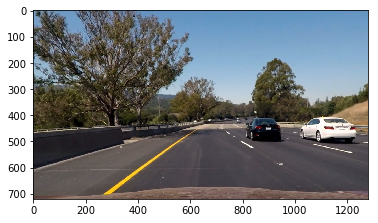

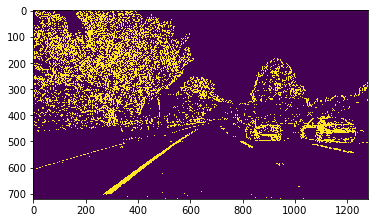

img.shape : (720, 1280)
warped.shape : (720, 1280)
warpped shape:  (720, 1280)


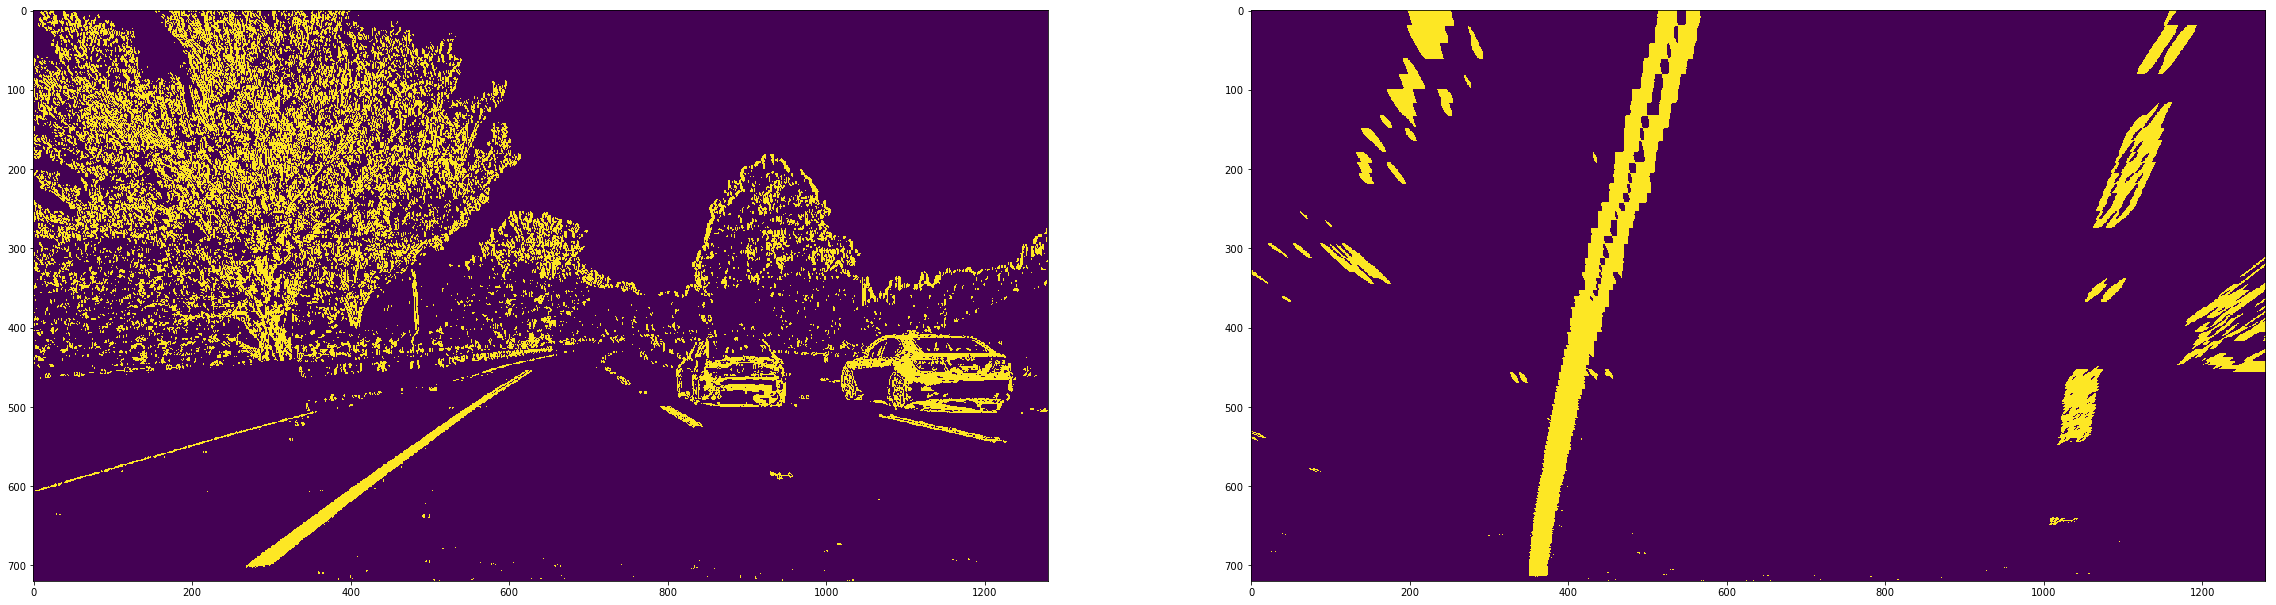

binary_warped.shape : (720, 1280)
out_img.shape : (720, 1280, 3)
midpoint : 640 leftx_base : 373 rightx_base : 1042
nonzero : (array([  0,   0,   0, ..., 719, 719, 719]), array([197, 198, 199, ..., 633, 655, 828])) nonzeroy : [  0   0   0 ..., 719 719 719] (51039,) nonzerox : [197 198 199 ..., 633 655 828] (51039,)
binary_warped.shape[0]-1 :  719
binary_warped.shape[0] :  720
left_fit:  [  1.47606884e-04  -3.73207667e-01   5.47568060e+02]
right_fit:  [  1.69785381e-04  -3.42902327e-01   1.17235472e+03]
pts_left:  [[[ 547.56805983    0.        ]
  [ 547.19499977    1.        ]
  [ 546.82223492    2.        ]
  ..., 
  [ 355.86123754  717.        ]
  [ 355.69984575  718.        ]
  [ 355.53874918  719.        ]]] pts shape:  (1, 1440, 2)


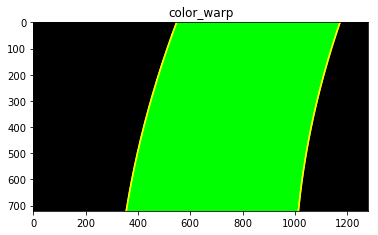

image.shape : (720, 1280, 3)
Minv:  [[  1.64792638e-01  -7.84202828e-01   5.35329567e+02]
 [ -3.33066907e-16  -5.14264809e-01   4.54644494e+02]
 [ -1.73472348e-18  -1.22613073e-03   1.00000000e+00]]


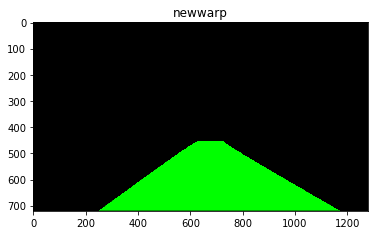

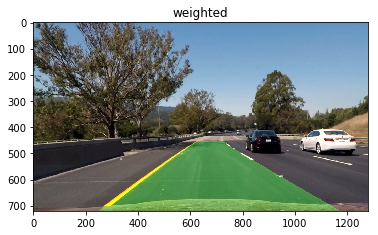

In [40]:
filename = 'test_images/test6.jpg'
#filename = 'test_images/straight_lines2.jpg'
#filename = 'test_images/solidYellowLeft.jpg'
#filename = 'test_images/test4.jpg'
image = mpimg.imread(filename)

undistorted = undistortImg(image)
plt.imshow(undistorted)
plt.show()
colorgrad = colorandgradient(undistorted )
plt.imshow(colorgrad)
plt.show()
#    hough = houghbinary(colorgrad)
warped, M, Minv = warp_image(colorgrad)
print('warpped shape: ', warped.shape)
plt.imshow(warped)
plt.show()
left_fit, right_fit = fitlanes(warped)
left_fitx, right_fitx, ploty = drawfit(warped, left_fit, right_fit)
drawwindow(warped)


# Create an image to draw the lines on
#warped = Line.warped
warp_zero = np.zeros_like(warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
print('pts_left: ', pts_left, 'pts shape: ', pts.shape)

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
plt.imshow(color_warp)
plt.title('color_warp')
plt.show()

print('image.shape :', image.shape)
# Warp the blank back to original image space using inverse perspective matrix (Minv)
Minv = Line.Minv
print('Minv: ', Minv)
#print('Line Minv: ', Line.Minv)

newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
#newwarp = cv2.warpPerspective(warped, Minv, (image.shape[1], image.shape[0]))
plt.imshow(newwarp)
plt.title('newwarp')
plt.show()

# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
plt.imshow(result)
plt.title('weighted')
plt.show()



img.shape : (720, 1280)
warped.shape : (720, 1280)
warpped shape:  (720, 1280)


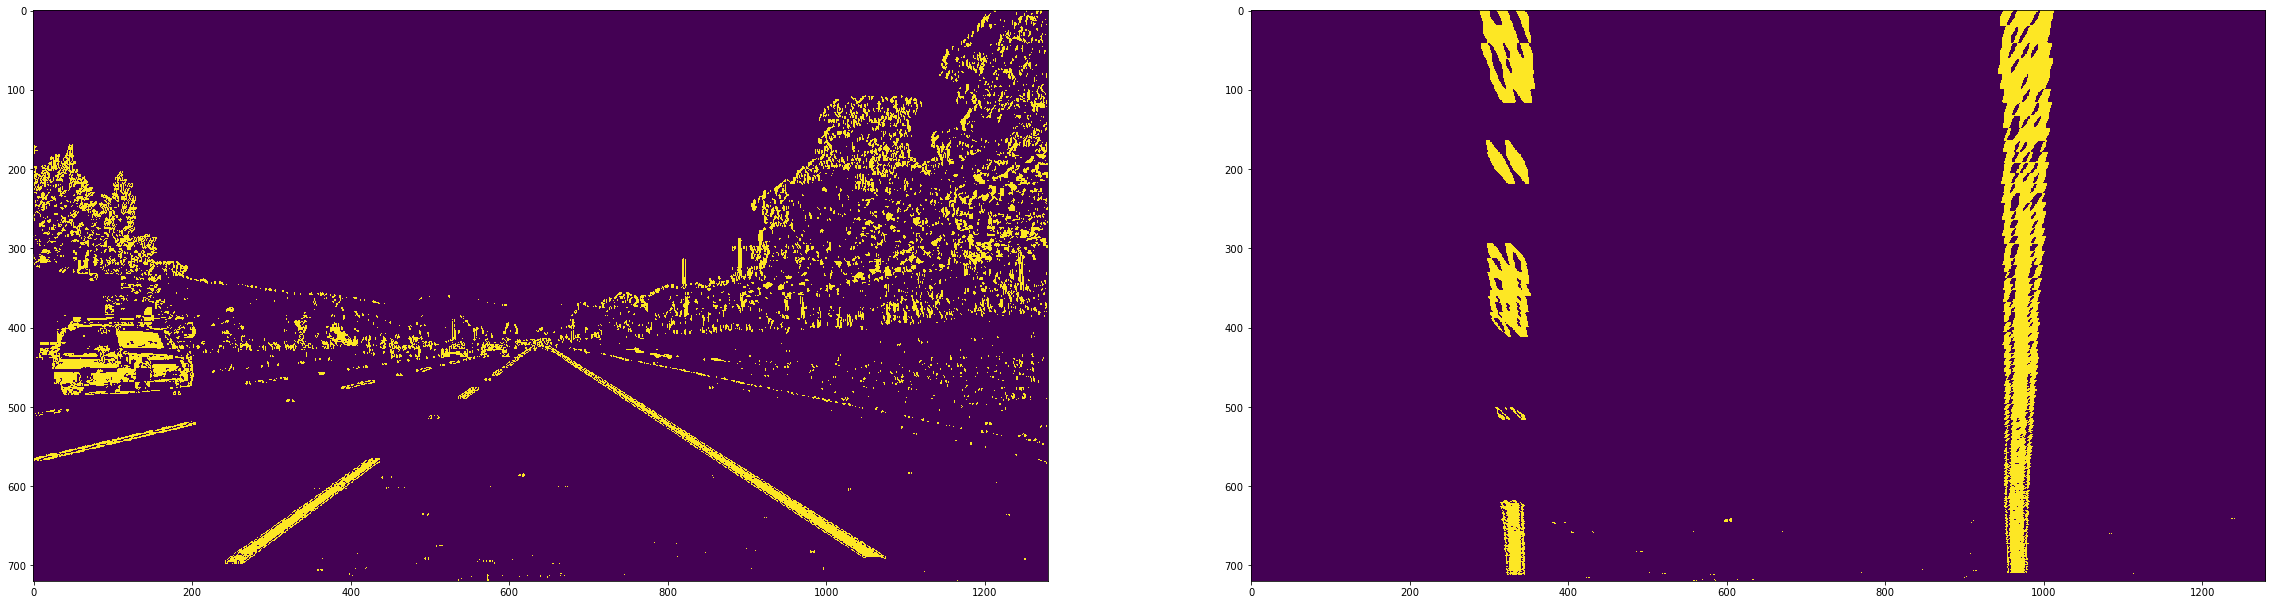

binary_warped.shape : (720, 1280)
out_img.shape : (720, 1280, 3)
midpoint : 640 leftx_base : 333 rightx_base : 973
nonzero : (array([  0,   0,   0, ..., 719, 719, 719]), array([288, 289, 290, ..., 559, 561, 585])) nonzeroy : [  0   0   0 ..., 719 719 719] (39335,) nonzerox : [288 289 290 ..., 559 561 585] (39335,)
binary_warped.shape[0]-1 :  719
binary_warped.shape[0] :  720
left_fit:  [  1.95837541e-05  -9.98056294e-04   3.24023055e+02]
right_fit:  [ -1.27097928e-05  -1.18488036e-02   9.78400855e+02]
Minv:  [[  1.64792638e-01  -7.84202828e-01   5.35329567e+02]
 [ -3.33066907e-16  -5.14264809e-01   4.54644494e+02]
 [ -1.73472348e-18  -1.22613073e-03   1.00000000e+00]]
Line Minv:  [[  1.64792638e-01  -7.84202828e-01   5.35329567e+02]
 [ -3.33066907e-16  -5.14264809e-01   4.54644494e+02]
 [ -1.73472348e-18  -1.22613073e-03   1.00000000e+00]]
pts_left:  [[[ 324.02305486    0.        ]
  [ 324.02207639    1.        ]
  [ 324.02113708    2.        ]
  ..., 
  [ 333.37524107  717.        ]
 

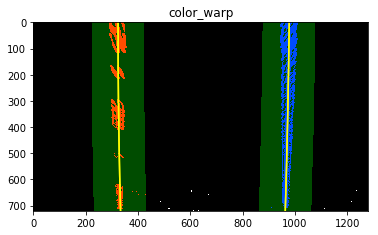

image.shape : (720, 1280, 3)


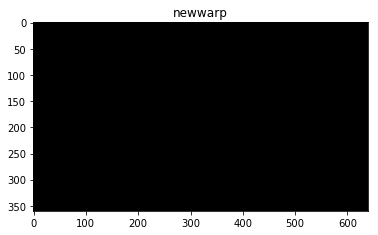

error: /io/opencv/modules/core/src/arithm.cpp:659: error: (-209) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function arithm_op


In [24]:
def process_one_image(image):
    frame = Line()
    undistorted = undistortImg(image)
#     plt.imshow(undistorted)
#     plt.show()
    colorgrad = colorandgradient(undistorted )
#     plt.imshow(colorgrad)
#     plt.show()
#    hough = houghbinary(colorgrad)
    warped, M, Minv = warp_image(colorgrad)
    print('warpped shape: ', warped.shape)
    plt.imshow(warped)
    plt.show()
    left_fit, right_fit = fitlanes(warped)
    left_fitx, right_fitx, ploty = drawfit(warped, left_fit, right_fit)
    drawwindow(warped)
    warpedback = drawwarpback(left_fitx, right_fitx, ploty)
#     image = undistortImg(image)
#     colorgrad = colorandgradient(image, (180, 255), (60, 100) )
#     plt.imshow(colorgrad)
#     plt.show()
    return warpedback

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return process_one_image(image)


filename = 'test_images/straight_lines2.jpg'
image = mpimg.imread(filename)
processed = process_one_image(image)



In [18]:
interrupt

NameError: name 'interrupt' is not defined

In [ ]:
# make sure the output folder exist.
import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

outputdir = 'test_videos_output'
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
    
white_output = outputdir + '/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



In [ ]:

interrupt


## Helper Functions
Copied from P1 lane lines


In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)
   
    
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


       
    